<a href="https://colab.research.google.com/github/taeheee-kim/deep_learning_practice/blob/master/%EC%BD%94%EB%93%9C%20%EC%88%98%EC%A0%95_transform%20%EB%B0%8F%20graph%20%EA%B7%B8%EB%A6%AC%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!nvidia-smi

In [2]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

albumentations==1.1.0 is successfully installed


## Run the example

### Import the required libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

cudnn.benchmark = True

In [5]:
import gc
import torch
import torch.utils.data as Data
import torch.nn as nn
from torchvision import transforms, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


# 데이터 경로
data_path = '/content/drive/My Drive/Tomato_version2/'

train = pd.read_csv(data_path + 'train.csv')
#test = pd.read_csv(data_path + 'test.csv')
#submission = pd.read_csv(data_path + 'sample_submission.csv')

import torch # 파이토치
import random
import os


In [6]:
IMAGE_FOLDER = '/content/drive/My Drive/Tomato_version2/images/'

def get_image_path(filename):
  return (IMAGE_FOLDER + filename + '.png')

In [7]:

# 시드 값 고정
seed = 10
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from sklearn.model_selection import train_test_split

# 훈련 데이터, 검증 데이터 분리
train, valid = train_test_split(train,
                                test_size=0.1,
                                stratify=train[['Tomato_D01','Tomato_D04','Tomato_D05','Tomato_D07','Tomato_D08','Tomato_D09','Tomato_H','Tomato_P03','Tomato_P05','Tomato_R01']],
                                random_state=10)

import cv2
from torch.utils.data import Dataset  # 데이터 생성을 위한 클래스
import numpy as np
import glob
from albumentations import *
from albumentations.pytorch import ToTensorV2

class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir='./', is_test=False, is_train=True):
        super().__init__()  # 상속받은 Dataset의 __init__() 메서드 호출
        self.df = df
        self.img_dir = img_dir
        self.is_train = is_train
        self.is_test = is_test

        self.train_transform = Compose([HorizontalFlip(p=0.5),
                                        VerticalFlip(p=0.5),
                                        ShiftScaleRotate(
                                            shift_limit = 0.1,
                                            scale_limit = 0.2,
                                            rotate_limit = 25.0, 
                                            p=0.7),
                                        OneOf([IAAEmboss(p=1), 
                                               IAASharpen(p=1), 
                                               Blur(p=1)],p=0.5),
                                        IAAPiecewiseAffine(p=0.5)
                                        ])
        self.test_transform = Compose([HorizontalFlip(p=0.5),
                                       VerticalFlip(p=0.5),
                                       ShiftScaleRotate(rotate_limit = 25.0, p=0.7)])
        self.default_transform = Compose([Resize(400,600),
                                          Normalize(),
                                          ToTensorV2()])
    

    # 데이터 세트 크기 반환 메서드
    def __len__(self):
        return len(self.df)

    # 인덱스(idx)에 해당하는 데이터 반환 메서드
    def __getitem__(self, idx):
        
        img_id = self.df.iloc[idx, 0] # 이미지 ID
        img_path = self.img_dir + str(img_id) + '.png' # 이미지 파일 경로
        image = cv2.imread(img_path) # 이미지 파일 읽기
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
        
        # 이미지 변환
        if self.is_train :
          image = self.train_transform(image = image)['image']
          image = self.default_transform(image = image)['image']

        elif self.is_test :
          image = self.test_transform(image = image)['image']
          image = self.default_transform(image = image)['image']

        else :
          image = self.default_transform(image = image)['image']


        # 테스트 데이터면 이미지 데이터만 반환, 그렇지 않으면 타깃 값(label)도 함께 반환
        if self.is_test:
            return image
        else:
            # 타깃 값 4개 중 가장 큰 값의 인덱스
            label = np.argmax(self.df.iloc[idx, 1:11])
            return image, label

In [8]:
img_dir = '/content/drive/My Drive/Tomato_version2/images/'

dataset_train = ImageDataset(train, img_dir=img_dir, is_train=True)
dataset_valid = ImageDataset(valid, img_dir=img_dir, is_train=False, is_test=False)

In [9]:
def seed_worker(worker_id): #시드를 고정해주는 역할
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

In [10]:
from torch.utils.data import DataLoader # 데이터 로더 생성을 위한 클래스

batch_size = 6

loader_train = DataLoader(dataset_train, batch_size=batch_size, 
                          shuffle=True, worker_init_fn=seed_worker,
                          generator=g)
loader_valid = DataLoader(dataset_valid, batch_size=batch_size, 
                          shuffle=False, worker_init_fn=seed_worker,
                          generator=g)

In [11]:
!pip install efficientnet-pytorch==0.7.1

In [12]:
!pip install transformers

In [13]:
from efficientnet_pytorch import EfficientNet # EfficientNet 모델

# 사전 훈련된 efficientnet-b7 모델 불러오기

model = EfficientNet.from_pretrained('efficientnet-b6', num_classes=10) 

model = model.to(device) # 장비 할당

Loaded pretrained weights for efficientnet-b6


In [14]:
import torch.nn as nn # 신경망 모듈

# 손실함수
criterion = nn.CrossEntropyLoss()

# 옵티마이저
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00007, weight_decay=0.0001)

from transformers import get_cosine_schedule_with_warmup

epochs = 4 # 총 에폭

# 스케줄러
scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=len(loader_train)*5, 
                                            num_training_steps=len(loader_train)*epochs)


In [15]:
train_loss = []
valid_loss = []
train_acc = []
val_acc = []

In [18]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수
from tqdm.notebook import tqdm # 진행률 표시 막대
from sklearn.metrics import accuracy_score

# 총 에폭만큼 반복
for epoch in range(epochs):

    #train
    model.train() # 모델을 훈련 상태로 설정
    epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
    preds_for_acc = [] # 예측값
    labels_for_acc = [] # 실제 값


    # '반복 횟수'만큼 반복 
    for images, labels in tqdm(loader_train):
    
        # 이미지, 레이블(타깃 값) 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)

        # 현재 배치에서의 손실 추가 (훈련 데이터용)
        epoch_train_loss += loss.item() 
        # 영어 코드에서는 loss.item()에 labels.shape[0]을 곱해주는데 이건 왜 그러는지 모르겠넹

        # 역전파 수행
        loss.backward() 
        # 가중치 갱신
        optimizer.step() 
        # 스케줄러 학습률 갱신
        scheduler.step() 

        #영어 코드 복붙
        labels_for_acc = np.concatenate((labels_for_acc, labels.cpu().numpy()),0)
        preds_for_acc = np.concatenate((preds_for_acc, np.argmax(outputs.cpu().detach().numpy(),1)),0)
        
    if (epoch+1)%5==0: #5 10,15 20, 30, ... 
          path = '/content/drive/My Drive/Tomato_version2/check/epoch' + str(epoch) + '.pt'
          torch.save(model.state_dict(), path)

    ta = accuracy_score(labels_for_acc, preds_for_acc)
    tl = epoch_train_loss/len(loader_train)

    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
    

    # validation
    
    model.eval() # 모델을 평가 상태로 설정 
    epoch_valid_loss = 0 # 에폭별 손실값 초기화 (검증 데이터용) 
    preds_list = [] # 예측 확률값 저장용 리스트 초기화 
    true_list = [] # 실제 타깃 값 저장용 리스트 초기화 
    

    with torch.no_grad(): # 기울기 계산 비활성
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()
            
            true_list = np.concatenate((true_list, labels.cpu().numpy()),0)
            preds_list = np.concatenate((preds_list, np.argmax(outputs.cpu().detach().numpy(),1)),0)

            va = accuracy_score(true_list, preds_list)
            vl = epoch_valid_loss/len(loader_valid)
            
            
        # 검증 데이터 손실값 및 ROC AUC 점수 출력 
        print(f'에폭 [{epoch+1}/{epochs}] - 검증 데이터 손실값 : {vl} / 검증 데이터 ROC AUC : {va}')  

    

    train_loss.append(tl)
    valid_loss.append(vl)
    train_acc.append(ta)
    val_acc.append(va)

  0%|          | 0/536 [00:00<?, ?it/s]

에폭 [1/4] - 훈련 데이터 손실값 : 0.5902
에폭 [1/4] - 검증 데이터 손실값 : 0.23489872282370924 / 검증 데이터 ROC AUC : 0.9495798319327731


  0%|          | 0/536 [00:00<?, ?it/s]

에폭 [2/4] - 훈련 데이터 손실값 : 0.3543
에폭 [2/4] - 검증 데이터 손실값 : 0.13796140982303767 / 검증 데이터 ROC AUC : 0.969187675070028


  0%|          | 0/536 [00:00<?, ?it/s]

에폭 [3/4] - 훈련 데이터 손실값 : 0.2292
에폭 [3/4] - 검증 데이터 손실값 : 0.08960884932118157 / 검증 데이터 ROC AUC : 0.9803921568627451


  0%|          | 0/536 [00:00<?, ?it/s]

에폭 [4/4] - 훈련 데이터 손실값 : 0.1566
에폭 [4/4] - 검증 데이터 손실값 : 0.06287663440840939 / 검증 데이터 ROC AUC : 0.9831932773109243


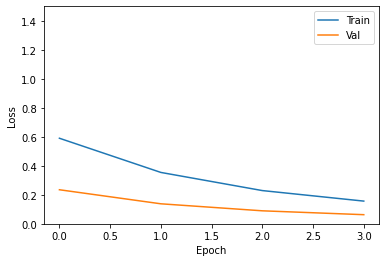

In [19]:
plt.figure()
plt.ylim(0,1.5)
sns.lineplot(list(range(len(train_loss))), train_loss)
sns.lineplot(list(range(len(valid_loss))), valid_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Val'])

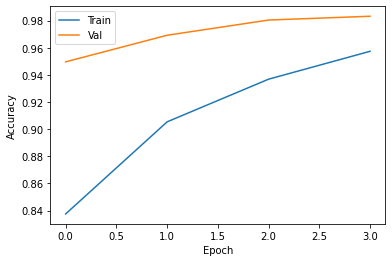

In [20]:
plt.figure()
sns.lineplot(list(range(len(train_acc))), train_acc)
sns.lineplot(list(range(len(val_acc))), val_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Val'])

In [ ]:
#PATH = '/content/drive/My Drive/Tomato_version2/'

#모델 저장하기
#torch.save(model, PATH + 'model.pt')

In [ ]:
#테스트 사진으로 평가 후 csv 채워넣기

In [ ]:
#test = pd.read_csv(data_path + 'test.csv')
#submission = pd.read_csv(data_path + 'sample_submission.csv')

In [ ]:
#img_dir = '/content/drive/My Drive/Tomato_version2/test_images/'

#dataset_TTA = ImageDataset(test, img_dir=img_dir, 
                           #transform=transform_train, is_test=True)
#loader_TTA = DataLoader(dataset_TTA, batch_size=batch_size, 
                        #shuffle=False, worker_init_fn=seed_worker,
                        #generator=g)

In [ ]:
'''
num_TTA = 5 # TTA 횟수

preds_tta = np.zeros((len(test), 10)) # 예측 값 저장용 배열 초기화 (TTA용)

# TTA를 적용해 예측 (5에폭)
for i in range(num_TTA):
    with torch.no_grad():
        for i, images in enumerate(loader_TTA):
            images = images.to(device)
            outputs = model(images)
            # 타깃 예측 확률
            preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
            preds_tta[i*batch_size:(i+1)*batch_size] += preds_part
            '''

In [ ]:
#preds_tta /= num_TTA 

In [ ]:
'''
submission_tta = submission.copy() 

submission_tta[['Tomato_D01','Tomato_D04','Tomato_D05','Tomato_D07','Tomato_D08','Tomato_D09','Tomato_H','Tomato_P03','Tomato_P05','Tomato_R01']] = preds_tta
'''

In [ ]:
#submission_tta

In [ ]:
#id = submission_tta["file_name"]

In [ ]:
#pred_idx = np.argmax(preds_tta, axis=1)  #확률 중 가장 높은 값의 인덱스를 0 ~ 9까지 반환

In [ ]:
#pred_idx

In [ ]:
#df = pd.DataFrame({'file_name':id, 'answer':pred_idx})

In [ ]:
#df 

In [ ]:
#df.to_csv('/content/drive/My Drive/Tomato_version2/submission_tta.csv', index=False)